# Overview

It only takes one toxic comment to sour an online discussion. The Conversation AI team, a research initiative founded by [Jigsaw](https://jigsaw.google.com/) and Google, builds technology to protect voices in conversation. A main area of focus is machine learning models that can identify toxicity in online conversations, where toxicity is defined as anything *rude, disrespectful or otherwise likely to make someone leave a discussion*. Our API, [Perspective](http://perspectiveapi.com/), serves these models and others in a growing set of languages (see our [documentation](https://github.com/conversationai/perspectiveapi/blob/master/2-api/models.md#all-attribute-types) for the full list). If these toxic contributions can be identified, we could have a safer, more collaborative internet.

In this competition, we'll explore how models for recognizing toxicity in online conversations might generalize across different languages. Specifically, in this notebook, we'll demonstrate this with a multilingual BERT (m-BERT) model. Multilingual BERT is pretrained on monolingual data in a variety of languages, and through this learns multilingual representations of text. These multilingual representations enable *zero-shot cross-lingual transfer*, that is, by fine-tuning on a task in one language, m-BERT can learn to perform that same task in another language (for some examples, see e.g. [How multilingual is Multilingual BERT?](https://arxiv.org/abs/1906.01502)).

We'll study this zero-shot transfer in the context of toxicity in online conversations, similar to past competitions we've hosted ([[1]](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification), [[2]](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)). But rather than analyzing toxicity in English as in those competitions, here we'll ask you to do it in several different languages. For training, we're including the (English) datasets from our earlier competitions, as well as a small amount of new toxicity data in other languages.

In [1]:
import os, time, logging
import tensorflow as tf
import tensorflow_hub as hub
from matplotlib import pyplot as plt
print(tf.version.VERSION)
tf.get_logger().setLevel(logging.ERROR)

2.2.0-dlenv


# TPU or GPU detection

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.MirroredStrategy() # works on GPU and multi-GPU
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    tf.config.optimizer.set_jit(True) # XLA compilation
    tf.keras.mixed_precision.experimental.set_policy(policy)
    print('Mixed precision enabled')

print("REPLICAS: ", strategy.num_replicas_in_sync)

# mixed precision
# On TPU, bfloat16/float32 mixed precision is automatically used in TPU computations.
# Enabling it in Keras also stores relevant variables in bfloat16 format (memory optimization).
# This additional optimization was not used for TPUs in this sample.
# On GPU, specifically V100, mixed precision must be enabled for hardware TensorCores to be used.
# XLA compilation must be enabled for this to work. (On TPU, XLA compilation is the default and cannot be turned off)

REPLICAS:  8


# Configuration
Set maximum sequence length and path variables.

Learning rate schedule:


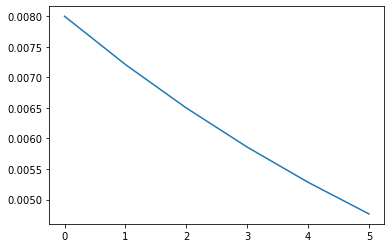

In [3]:
SEQUENCE_LENGTH = 128

# Copy of the TF Hub model at https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/1
BERT_GCS_PATH = 'gs://bert_multilingual_public/bert_multi_cased_L-12_H-768_A-12_2/'
EPOCHS = 6

# select the GCS bucket closest to your accelerator
GCS_PATH = 'gs://jigsaw_multilingual_toxic_comments_public/data'  # US
#GCS_PATH = 'gs://jigsaw_multilingual_toxic_comments_public_euwest/data' # eu-west4

if tpu:
    BATCH_SIZE = 128 * strategy.num_replicas_in_sync
else:
    BATCH_SIZE = 64 * strategy.num_replicas_in_sync

TRAIN_DATA = GCS_PATH + "/jigsaw-toxic-comment-train-processed-seqlen{}.csv".format(SEQUENCE_LENGTH)
TRAIN_DATA_LENGTH = 223549 # rows
VALID_DATA = GCS_PATH + "/validation-processed-seqlen{}.csv".format(SEQUENCE_LENGTH)
STEPS_PER_EPOCH = TRAIN_DATA_LENGTH // BATCH_SIZE

LR_MAX = 0.001 * strategy.num_replicas_in_sync
LR_EXP_DECAY = .9
LR_MIN = 0.0001

@tf.function
def lr_fn(epoch):
    lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch) + LR_MIN
    return lr

print("Learning rate schedule:")
rng = [i for i in range(EPOCHS)]
y = [lr_fn(x) for x in rng]
plt.plot(rng, [lr_fn(x) for x in rng])
plt.show()

# Model

Define the model. We convert m-BERT's output to a final probabilty estimate. We're using an [m-BERT model from TensorFlow Hub](https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/1).

In [4]:
def multilingual_bert_model(max_seq_length=SEQUENCE_LENGTH):
    """Build and return a multilingual BERT model and tokenizer."""
    input_word_ids = tf.keras.layers.Input(
        shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(
        shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.layers.Input(
        shape=(max_seq_length,), dtype=tf.int32, name="all_segment_id")
    
    bert_layer = tf.saved_model.load(BERT_GCS_PATH)  # copy of TF Hub model 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/1'
    bert_layer = hub.KerasLayer(bert_layer, trainable=True)

    pooled_output, _ = bert_layer([input_word_ids, input_mask, segment_ids])
    output = tf.keras.layers.Dense(32, activation='relu')(pooled_output)
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='labels', dtype=tf.float32)(output)

    return tf.keras.Model(inputs={'input_word_ids': input_word_ids,
                                  'input_mask': input_mask,
                                  'all_segment_id': segment_ids},
                          outputs=output)

# Dataset
Load the preprocessed dataset. See the demo notebook for sample code for performing this preprocessing.

In [5]:
def parse_string_list_into_ints(strlist):
    s = tf.strings.strip(strlist)
    s = tf.strings.substr(
        strlist, 1, tf.strings.length(s) - 2)  # Remove parentheses around list
    s = tf.strings.split(s, ',', maxsplit=SEQUENCE_LENGTH)
    s = tf.strings.to_number(s, tf.int32)
    s = tf.reshape(s, [SEQUENCE_LENGTH])  # Force shape here needed for XLA compilation (TPU)
    return s

def format_sentences(data, label='toxic', remove_language=False):
    labels = {'labels': data.pop(label)}
    if remove_language:
        languages = {'language': data.pop('lang')}
    # The remaining three items in the dict parsed from the CSV are lists of integers
    for k,v in data.items():  # "input_word_ids", "input_mask", "all_segment_id"
        data[k] = parse_string_list_into_ints(v)
    return data, labels

def make_sentence_dataset_from_csv(filename, label='toxic', language_to_filter=None):
    # This assumes the column order label, input_word_ids, input_mask, segment_ids
    SELECTED_COLUMNS = [label, "input_word_ids", "input_mask", "all_segment_id"]
    label_default = tf.int32 if label == 'id' else tf.float32
    COLUMN_DEFAULTS  = [label_default, tf.string, tf.string, tf.string]

    if language_to_filter:
        insert_pos = 0 if label != 'id' else 1
        SELECTED_COLUMNS.insert(insert_pos, 'lang')
        COLUMN_DEFAULTS.insert(insert_pos, tf.string)

    preprocessed_sentences_dataset = tf.data.experimental.make_csv_dataset(
        filename, column_defaults=COLUMN_DEFAULTS, select_columns=SELECTED_COLUMNS,
        batch_size=1, num_epochs=1, shuffle=False)  # We'll do repeating and shuffling ourselves
    # make_csv_dataset required a batch size, but we want to batch later
    preprocessed_sentences_dataset = preprocessed_sentences_dataset.unbatch()
    
    if language_to_filter:
        preprocessed_sentences_dataset = preprocessed_sentences_dataset.filter(
            lambda data: tf.math.equal(data['lang'], tf.constant(language_to_filter)))
        #preprocessed_sentences.pop('lang')
    preprocessed_sentences_dataset = preprocessed_sentences_dataset.map(
        lambda data: format_sentences(data, label=label,
                                      remove_language=language_to_filter))

    return preprocessed_sentences_dataset

Set up our data pipelines for training and evaluation.

In [6]:
def make_dataset_pipeline(dataset, repeat_and_shuffle=True):
    """Set up the pipeline for the given dataset.
    
    Caches, repeats, shuffles, and sets the pipeline up to prefetch batches."""
    cached_dataset = dataset.cache()
    if repeat_and_shuffle:
        cached_dataset = cached_dataset.repeat().shuffle(2048)
        cached_dataset = cached_dataset.batch(BATCH_SIZE, drop_remainder=True) # no remainder on repeated dataset
    else:
        cached_dataset = cached_dataset.batch(BATCH_SIZE)
    cached_dataset = cached_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return cached_dataset

# Load the preprocessed English dataframe.
preprocessed_en_filename = TRAIN_DATA

# Set up the dataset and pipeline.
english_train_dataset = make_dataset_pipeline(
    make_sentence_dataset_from_csv(preprocessed_en_filename))

# Process the new datasets by language.
preprocessed_val_filename = VALID_DATA

nonenglish_val_datasets = {}
for language_name, language_label in [('Spanish', 'es'), ('Italian', 'it'),
                                      ('Turkish', 'tr')]:
    nonenglish_val_datasets[language_name] = make_sentence_dataset_from_csv(
        preprocessed_val_filename, language_to_filter=language_label)
    nonenglish_val_datasets[language_name] = make_dataset_pipeline(
        nonenglish_val_datasets[language_name], repeat_and_shuffle=False)

nonenglish_val_datasets['Combined'] = make_sentence_dataset_from_csv(preprocessed_val_filename)
nonenglish_val_datasets['Combined'] = make_dataset_pipeline(nonenglish_val_datasets['Combined'], repeat_and_shuffle=False)

# Instantiate the model

Compile our model. We will fine-tune the multilingual model on one of our English datasets, and then evaluate its performance on the new multilingual toxicity data. As our metric, we'll use the [AUC](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC).

In [7]:
with strategy.scope():
    multilingual_bert = multilingual_bert_model()

    # Compile the model. Optimize using stochastic gradient descent.
    multilingual_bert.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.001*strategy.num_replicas_in_sync),
        metrics=[tf.keras.metrics.AUC()])

multilingual_bert.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
all_segment_id (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [8]:
%%time
# Train on English Wikipedia comment data.
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_fn)
history = multilingual_bert.fit(
    english_train_dataset, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS,
    #validation_data=nonenglish_val_datasets['Combined'],
    callbacks=[lr_callback])

Epoch 1/6


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


218/218 [==============================] - 61s 279ms/step - loss: 0.2377 - auc: 0.8477 - lr: 0.0080
Epoch 2/6
218/218 [==============================] - 61s 279ms/step - loss: 0.1466 - auc: 0.9510 - lr: 0.0072
Epoch 3/6
218/218 [==============================] - 61s 279ms/step - loss: 0.1278 - auc: 0.9637 - lr: 0.0065
Epoch 4/6
218/218 [==============================] - 61s 279ms/step - loss: 0.1195 - auc: 0.9684 - lr: 0.0059
Epoch 5/6
218/218 [==============================] - 61s 279ms/step - loss: 0.1152 - auc: 0.9708 - lr: 0.0053
Epoch 6/6
218/218 [==============================] - 61s 279ms/step - loss: 0.1120 - auc: 0.9722 - lr: 0.0048
CPU times: user 24.1 s, sys: 1.48 s, total: 25.6 s
Wall time: 6min 37s


In [9]:
# Performance on non-English comments after training.
for language in nonenglish_val_datasets:
    results = multilingual_bert.evaluate(nonenglish_val_datasets[language], verbose=0)
    print('{} loss, AUC after training:'.format(language), results)

Spanish loss, AUC after training: [0.5057603120803833, 0.8341767191886902]
Italian loss, AUC after training: [0.5645029544830322, 0.7703384757041931]
Turkish loss, AUC after training: [0.320696622133255, 0.9263491630554199]
Combined loss, AUC after training: [0.4547185003757477, 0.8328021764755249]


# License

Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
